In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [82]:
deep_reload(src)
from scipy.stats import norm

a = np.random.rand(30)

src.routing.super_quantile(a, (.5, .99)), norm(*norm.fit(a)).ppf(.75)

(0.7535374243641246, 0.6286371521508285)

In [92]:
deep_reload(src)

a = np.random.rand(30)

np.quantile(a, .75), norm(*norm.fit(a)).ppf(.75)

(0.7160028853362782, 0.6769262960705204)

In [97]:
# Generating random graph
deep_reload(src)

# Seed for replication
seed = np.random.randint(0, sys.maxsize)
# seed = 1893652
# seed = 8088012226794766477
seed = 7060991807081201953
print(seed)
rng = np.random.default_rng(seed)

# Numbers of nodes origins, destinations, and chargers
n_nodes = 100
p_edge = 1/10
reference_distance = 200e3
n_origins = 1
n_destinations = 5
n_chargers = 15

# Graph parameters
scale = (.9e6, .9e6) # graph scale [m]
link_speeds = [105 / 3.6] # Possible values for link speeds [m/s]

# Graph generation
graph = src.rng.random_graph(
    n_nodes,
    reference_distance = reference_distance,
    scale = scale,
    link_speeds = link_speeds,
    seed = seed,
)

# Origins and Destinations
origin_nodes, destination_nodes = src.rng.random_origin_destination(
    graph, n_origins, n_destinations, seed = seed)

veh = src.routing.ConstrainedVehicle(
    n_cases = 30,
    # risk_attitude = (0, .5),
    risk_attitude = (.5, 1),
)

# Chargers to add to charger nodes
charger = src.routing.Station(
    veh,
    reliability = .5,
    chargers = 10,
    # reliability = 1,
)

functions = charger.update

graph_nc = graph.copy()

# Adding to graph
graph, assigned_nodes = src.rng.random_attribute_assignment(
    graph, 'functions', [functions] * n_chargers, rng
)

7060991807081201953


In [100]:
deep_reload(src)

t0 = time.time()

expectations, values, paths = veh.routes(
    graph,
    origins = origin_nodes,
    # destinations = [0, 55, 66],
    return_paths = True
)

time.time() - t0

0.23720169067382812

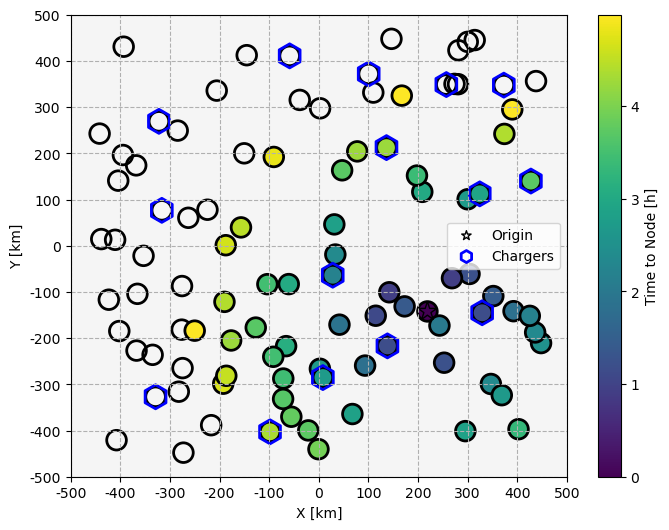

In [101]:
deep_reload(src)

path_values_avg = {}

key = 'time'

for target, value in values.items():

    path_values_avg[target] = {}

    val = value['soc']

    soc_end = src.routing.super_quantile(val, (0, 1)) > .2

    if soc_end:

        val = value[key]
    
        path_values_avg[target][key] = src.routing.super_quantile(val, (0, 1)) / 3.6e3

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output_cali(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = key)

_ = ax.set_xticks(
    np.linspace(-.5, .5, 11) * 1e6,
    np.round(np.linspace(-.5, .5, 11) * 1e3).astype(int)
)

_ = ax.set_yticks(
    np.linspace(-.5, .5, 11) * 1e6,
    np.round(np.linspace(-.5, .5, 11) * 1e3).astype(int)
)

_ = ax.set(**{
    'facecolor': 'whitesmoke',
    'xlim': [-.5e6, .5e6],
    'ylim': [-.5e6, .5e6],
    'xlabel': 'X [km]',
    'ylabel': 'Y [km]',
})
_ = ax.grid(ls = '--')

# fig.savefig('Paper/figs/interactions_lc.png', bbox_inches = 'tight', dpi = 300)